<a href="https://colab.research.google.com/github/emilycalvert/scripts_cite/blob/main/analisis_salud_bosque_ejemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datos publicado de European Union/ESA/Copernicus y Google Earth Engine: [Sentinel-2 MSI: MultiSpectral Instrument, Level-2A](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#terms-of-use)

## 1. Alistar entorno.

In [1]:
!pip install numpy
!pip install geopy
!pip install pandas
!pip install pyproj
!pip install geemap
!pip install timedelta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for timedelta: filename=timedelta-2020.12.3-py3-none-any.whl size=1554 sha256=08a207b69ea1f5e478c277180679639dccd5e4cfb0c7877a90750efb6087f9e9
  Stored in directory: /root/.cache/pip/wheels/be/c0/1f/843bd73679dc7dfb26758c4effc6e273d3eebf2da2a35082b1
Successfully built timedelta


In [2]:
import ee
import time
import geemap
import datetime
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Transformer, Proj, transform
from dateutil.relativedelta import relativedelta

# **Recopilar, Proceso Datos, y Analizar NDVI**

### **1. Autorizar e inicializar Earth Engine**
#### _Autenticar e inicializar la API de Google Earth Engine (GEE)._




- Conecte e inicialice con tu cuenta de earth engine y proyecto.

In [3]:
ee.Authenticate(auth_mode="notebook")
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=WqmpYgfmDNhCLl3r0L4E8lI75EMLD-CGIvOLqd0da98&tc=ESbzjehoji-rWdvD72axTPAK2LOjYXL8Pwo1G3bS7ro&cc=n4kDUbiNskfICLzhVSUxFMfm9Vp64D8TPA1caQMS_5M

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AeaYSHCydO-RkJDgI8-tlG8hbjBo4ccM_l1YiNFCRYS2Cww-r7OwaLzEC6k

Successfully saved authorization token.


## **2. Cargar CSV**

#### _Cargue el archivo CSV que contiene las coordenadas y analícelo para crear puntos._

- Exporta tu hoja de cálculo con los vértices como csv. La integridad y uniformidad del documento original es importante. Si tiene dificultades en este paso, consulte el curso [aquí.](https://www.youtube.com/watch?v=uGx0PHD6o9M)

- Al usar este cuaderno en colab. Habrá un panel a la izquierda. Si no estás en los archivos. Haga clic en el icono de la carpeta donde los botones están al ras de la pantalla. Ahora donde dice "Archivos", haz clic en el ícono de archivo con una flecha en el medio y sube tus vértices. Alternativamente, puede arrastrar y soltar en el panel de archivos.

In [4]:
# @title
csv_viaje = 'imazacoord_NOppi.csv'  # Una vez que haya cargado su archivo, en esta línea cambie el nombre por el nombre del archivo que cargó con la extensión.
df = pd.read_csv(csv_viaje)

In [5]:
# @title
df.head()

,NCONTRA,NOMTIT,NUMRUC,RESAPR,ESTE,NORTE,VERTICE
0,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,643560.25,9530613.00,1
1,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,643560.25,9527597.60,2
2,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,641579.82,9528512.95,3
3,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,640464.65,9528511.51,4
4,16-IQU/C-J-105-04,INDUSTRIAL MADERERA ZAPOTE S.A.,20103979529,RSD N° 019-2012-GRL-GGR-PRMRFFS-DER-SDPM,638560.25,9526722.71,5


In [6]:
# Aquí necesitamos proyectar desde UTM 18S a WGS84 (el CRS utilizado por Earth Engine).
transformer = Transformer.from_crs("epsg:32718", "epsg:4326", always_xy=True)
'''
Tenga en cuenta que si sus coordenadas no están en UTM 18S,
deberá consultar la documentación de pyproj y ajustar "epsg:32718"
al epsg que utilizan sus coordenadas. Aquí está el sitio donde
puedes encontrar esa información:
https://pyproj4.github.io/pyproj/stable/api/crs/crs.html
https://epsg.io/
'''
def utm_to_latlon(easting, northing):
    # Dado que transformador.transform(este, norte) ya se alinea con (x, y) => (ESTE, NORTE),
    # y desea regresar (latitud, longitud), asegúrese de capturar la salida correctamente.
    lon, lat = transformer.transform(easting, northing)
    return lat, lon  # Esto garantiza que la devolución esté en formato (latitud, longitud).

# Assuming 'df' is your DataFrame
df['latitud'], df['longitud'] = zip(*df.apply(lambda row: utm_to_latlon(row['ESTE'], row['NORTE']), axis=1)) # Donde dice 'ESTE' y 'NORTE', esto coincide de manera muy idéntica con los nombres de las columnas de latitud y longitud en sus datos.

#### Procesando

In [7]:
coordenadas = df[['latitud', 'longitud']].values.tolist()

In [8]:
puntos = [ee.Feature(ee.Geometry.Point([lon, lat])) for lat, lon in coordenadas]
puntos_fc = ee.FeatureCollection(puntos)

In [9]:
polygon = ee.Geometry.Polygon([[[lon, lat] for lat, lon in coordenadas]])

In [10]:
centroid = polygon.centroid(maxError=1)

#### Modificar

In [11]:
print(centroid.getInfo())

{'type': 'Point', 'coordinates': [-73.72766753816298, -4.349379692587443]}


In [12]:
centro= (-73.72766753816298, -4.349379692587443) # Aquí pegue las coordenadas impresas en la celda de arriba para definir el centro de su parcela.

## **3. Obtener imágenes:**

#### _Utilice la API de Earth Engine para consultar imágenes para las fechas y la cobertura de nubes especificadas._


In [91]:
antes = '2020-01-06'
'''
Establezca esto en una fecha anterior a la emisión del permiso.
Encontrará la primera imagen de satélite en esa fecha o antes que
cumpla con sus requisitos de cobertura de nubes.
'''
despues = '2023-01-06'
'''
Esta fecha es posterior a la cosecha y encontrará
una imagen para la fecha más cercana pero no anterior
a la cosecha que cumpla con el umbral de nubosidad.
'''
limite_coberatura_nubes = 15  # Establezca esto en su umbral máximo de cobertura de nubes.

In [92]:
antes_fecha = datetime.strptime(antes, '%Y-%m-%d')
antes1= antes_fecha + relativedelta(years=-1)

In [93]:
ahora= datetime.now()
ahora = ahora.strftime('%Y-%m-%d')

In [94]:
# @title
# Imagen antes de la emisión del permiso.
image1 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
           .filterDate(antes1, antes) \
           .filterBounds(puntos_fc) \
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', limite_coberatura_nubes)) \
           .sort('CLOUDY_PIXEL_PERCENTAGE') \
           .first()\
           .clip(polygon)

In [95]:
nir1 = image1.select('B8')
red1 = image1.select('B4')


ndvi1 = nir1.subtract(red1).divide(nir1.add(red1)).rename('NDVI')

In [96]:
# @title
ndvi_antes = ndvi1.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
)

ndvi_antes = ndvi_antes.get('NDVI').getInfo()

print('NDVI Antes:', ndvi_antes)

NDVI Antes: 0.8255680912098503


In [97]:
date = ee.Date(image1.get('system:time_start')).format('YYYY-MM-dd')
print('Date of the image1:', date.getInfo())

Date of the image1: 2019-08-09


In [98]:
# @title
# Aquí está la foto después de la cosecha.
image2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
           .filterDate(despues, ahora) \
           .filterBounds(puntos_fc) \
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', limite_coberatura_nubes)) \
           .sort('CLOUDY_PIXEL_PERCENTAGE') \
           .first()\
           .clip(polygon)

In [99]:
nir2 = image2.select('B8')
red2 = image2.select('B4')

ndvi2 = nir2.subtract(red2).divide(nir2.add(red2)).rename('NDVI')

In [100]:
# Print the date of the image2 image
date_image2 = ee.Date(image2.get('system:time_start')).format('YYYY-MM-dd')
print('Date of the image2:', date_image2.getInfo())

Date of the image2: 2023-09-17


In [101]:
# @title
ndvi_despues = ndvi2.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
)

ndvi_despues = ndvi_despues.get('NDVI').getInfo()

print('NDVI Despues:', ndvi_despues)


NDVI Despues: 0.8451962613228494


#### Estilo

In [102]:
vizParams = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 2500,
    'gamma': 1.0
}

## **Antes**

In [103]:
# @title
# Aquí vemos la trama previa a la emisión del permiso.
# https://colab.research.google.com/github/giswqs/gee-tutorials/blob/master/Image/image_visualization.ipynb#scrollTo=dIqOCYLbo0SF

Map = geemap.Map()

Map.centerObject(polygon, 11)
Map.addLayer(image1, vizParams, 'Antes Permiso')

Map

Map(center=[-4.349379692587443, -73.72766753816298], controls=(WidgetControl(options=['position', 'transparent…

## **4. Calcular NDVI:**
#### _Calcular y enmascarar áreas donde se excede el umbral._

Aquí puede ver áreas de pérdida de vegetación en rojo y áreas de ganancia en verde dentro del umbral establecido.


NOTA IMPORTANTE: Si el NDVI antes es menor que el NDVI después indica un aumento en la vegetación. Establezca el umbral de pérdida en un número negativo y gane en un número positivo. Se aplica lo contrario.

In [104]:
# @title
ndvi_diff = ndvi2.subtract(ndvi1)

In [105]:
# @title
gain_threshold = 0.1

gain_mask = ndvi_diff.gt(gain_threshold)

pixelAreaGain = ee.Image.pixelArea().mask(gain_mask)
totalGainArea = pixelAreaGain.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
).get('area').getInfo()

print(f"Areas of Vegetation Gain: {totalGainArea} square meters")

Areas of Vegetation Gain: 4857539.131567382 square meters


In [106]:
# @title
loss_threshold = -0.1

loss_mask = ndvi_diff.lt(loss_threshold)

pixelAreaLoss = ee.Image.pixelArea().mask(loss_mask)
totalLossArea = pixelAreaLoss.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
).get('area').getInfo()

print(f"Areas of Vegetation Loss: {totalLossArea} square meters")

Areas of Vegetation Loss: 971196.2902937346 square meters


## **Despues**

Para futuras investigaciones nos acercamos a las áreas donde la reforestación estuvo presente. A partir de ahí podemos entender más de lo que pasó con esa tierra durante ese tiempo. Este es simplemente el código para ejecutar análisis adicionales.

In [107]:
# @title
gainStyle = {
    'color': '00FF00',
    'fillColor': '00000000'
}

lossStyle = {
    'color': 'FF0000',
    'fillColor': '00000000'
}

geometry = image2.geometry()

vectorizedGain = gain_mask.updateMask(gain_mask).reduceToVectors(
    geometry= geometry,
    geometryType='polygon',
    reducer=ee.Reducer.countEvery(),
    scale=10,
    maxPixels=1e9
).map(lambda feature: ee.Feature(feature.geometry()))

vectorizedLoss = loss_mask.updateMask(loss_mask).reduceToVectors(
    geometry= geometry,
    geometryType='polygon',
    reducer=ee.Reducer.countEvery(),
    scale=100,
    maxPixels=1e9
).map(lambda feature: ee.Feature(feature.geometry()))

styledGainPolygons = vectorizedGain.style(color='00FF00', width=.75, fillColor='00000000')
styledLossPolygons = vectorizedLoss.style(color='FF0000', width=.75, fillColor='00000000')

Map = geemap.Map()
Map.centerObject(polygon, 11)
Map.addLayer(image2, vizParams, 'Despues Tallando')
Map.addLayer(styledGainPolygons, {}, 'Vegetation Gain')
Map.addLayer(styledLossPolygons, {}, 'Vegetation Loss')

Map

Map(center=[-4.349379692587443, -73.72766753816298], controls=(WidgetControl(options=['position', 'transparent…

# **Análisis exploratorio**

Correlation Analysis
For: Before and After, Mask of Gain, Mask of Loss

Actionable Insights
Futher Analysis
Create Engaging Plots

## EVI



#### Proceso

In [108]:
def calculate_ndvi(image, ndvi):
    return image.addBands(ndvi)

def calculate_evi(image):
    evi = image.expression(
        '2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ).rename('EVI')

    return image.addBands(evi)

image1_ndvi_evi = calculate_ndvi(image1, ndvi1)
image1_ndvi_evi = calculate_evi(image1_ndvi_evi)

image2_ndvi_evi = calculate_ndvi(image2, ndvi2)
image2_ndvi_evi = calculate_evi(image2_ndvi_evi)

In [109]:
image2_ndvi_evi

In [116]:
image2_change_EVI = image2_ndvi_evi.addBands(image1_ndvi_evi.select('EVI').subtract(image2_ndvi_evi.select('EVI')).rename('EVI_change'))

In [117]:
image2_change_EVI

In [118]:
image2_with_changes= image2_change_EVI.addBands(image1_ndvi_evi.select('NDVI').subtract(image2_ndvi_evi.select('NDVI')).rename('NDVI_change'))

In [119]:
image2_with_changes

#### __Valores positivos en bandas de cambio__
- __Valores positivos__ indican que el valor del índice (NDVI o EVI) ha aumentado desde la primera imagen (antes) a la segunda imagen (después). Esto puede sugerir diversos cambios ecológicos o ambientales, como:
  - __Crecimiento o recuperación de la vegetación:__ Un aumento en el NDVI o EVI generalmente indica más vegetación verde. Esto podría deberse a cambios estacionales, recuperación después de una perturbación o esfuerzos exitosos de reforestación/forestación.
  - __Cambio en la condición de los cultivos:__ En contextos agrícolas, un aumento podría reflejar las etapas de crecimiento de los cultivos, una mejor salud o prácticas de manejo efectivas.
  
####__Valores negativos en bandas de cambio__
- __Valores negativos__ significan que el valor del índice ha disminuido de la primera imagen a la segunda. Esta disminución puede ser indicativa de diferentes escenarios, tales como:
  - __Pérdida o degradación de la vegetación:__ Una disminución en el NDVI o EVI podría indicar pérdida de vegetación debido a la deforestación, perturbaciones naturales (incendios, sequías, plagas) o actividades humanas (desmonte de tierras, desarrollo urbano).
  - __Senescencia estacional o cosecha:__ En tierras agrícolas, podría ocurrir una disminución después de la cosecha o cuando los cultivos experimentan senescencia al final de su temporada de crecimiento.


#### __Consideraciones de interpretación__
__Contexto temporal:__ La interpretación de los cambios positivos y negativos depende en gran medida del contexto temporal de sus imágenes. Es necesario considerar las variaciones estacionales, las etapas fenológicas de la vegetación y eventos específicos (como perturbaciones).

__Magnitud del cambio:__ La importancia del cambio también importa. Las pequeñas fluctuaciones podrían estar dentro del rango de variabilidad normal, mientras que los cambios más grandes podrían significar cambios ecológicos o de cobertura del suelo más sustanciales.


__Contexto espacial:__ Las condiciones ambientales locales, los tipos de cobertura del suelo y las prácticas de uso del suelo pueden influir en los valores de referencia de NDVI y EVI y sus cambios. Por lo tanto, interpretar los cambios también requiere comprender el contexto espacial del área que se analiza.

#### _____

* Las áreas rojas indican dónde la salud o la cobertura de la vegetación han disminuido con el tiempo, posiblemente debido a la deforestación, la expansión urbana o eventos naturales como incendios.

* Las áreas verdes sugieren una mejora o aumento de la vegetación, lo que podría deberse a esfuerzos de reforestación, rebrote natural o cambios estacionales.

* Las áreas blancas muestran poco o ningún cambio, lo que indica una salud de la vegetación estable entre los dos períodos de tiempo.

In [120]:
print(image2_with_changes.bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'NDVI', 'EVI', 'EVI_change', 'NDVI_change']


In [122]:
# @title
Map = geemap.Map()

Map.addLayer(image1, vizParams, '1 True Color')
Map.addLayer(image2, vizParams, '2 True Color')

vis_params_change = {
    'min': -0.9,
    'max': 0.4,
    'palette': ['red', 'white', 'green']
}

ndvi_change = image2_with_changes.select('NDVI_change')
evi_change = image2_with_changes.select('EVI_change')

kernel = ee.Kernel.circle(radius=3, units='pixels')
ndvi_change_smoothed = ndvi_change.focal_mean(kernel=kernel)
evi_change_smoothed = evi_change.focal_mean(kernel=kernel)

Map.addLayer(ndvi_change_smoothed, vis_params_change, 'NDVI Change Smoothed', opacity=0.5)
Map.addLayer(evi_change_smoothed, vis_params_change, 'EVI Change Smoothed', opacity=0.5)

Map.centerObject(polygon, 11)

Map.addLayerControl()

Map

Map(center=[-4.349379692587443, -73.72766753816298], controls=(WidgetControl(options=['position', 'transparent…

### **Analisis**

#### _Es importante a saber que este analisis es limitado a las fronteras de IMAZA y dentro de nos periodo especificado del tiempo. Tambien elegio el limite del "cambio dramatico" en NDVI. Eso cuaderno sirve como un ejemplo a emepazar nos jornada al gestion de madera basdo en dato del salud de nos bosques._

#### EVI a NDVI a Vista General

In [123]:
stats_ndvi_change = image2_with_changes.select('NDVI_change').reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.minMax(),
        sharedInputs=True
    ).combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ).combine(
        reducer2=ee.Reducer.count(),
        sharedInputs=True
    ),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
)

mean_ndvi_change = stats_ndvi_change.get('NDVI_change_mean').getInfo()
min_ndvi_change = stats_ndvi_change.get('NDVI_change_min').getInfo()
max_ndvi_change = stats_ndvi_change.get('NDVI_change_max').getInfo()
stddev_ndvi_change = stats_ndvi_change.get('NDVI_change_stdDev').getInfo()
count_ndvi_change = stats_ndvi_change.get('NDVI_change_count').getInfo()

print(f"NDVI Change - Mean: {mean_ndvi_change}, Min: {min_ndvi_change}, Max: {max_ndvi_change}, StdDev: {stddev_ndvi_change}, Count: {count_ndvi_change}")

NDVI Change - Mean: -0.019628170112985278, Min: -0.756585509171463, Max: 0.6259374173102366, StdDev: 0.0297580856351676, Count: 531574


In [125]:
stats_evi_change = image2_with_changes.select('EVI_change').reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.minMax(),
        sharedInputs=True
    ).combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ).combine(
        reducer2=ee.Reducer.count(),
        sharedInputs=True
    ),
    geometry=polygon,
    scale=30,
    maxPixels=1e9
)

mean_evi_change = stats_evi_change.get('EVI_change_mean').getInfo()
min_evi_change = stats_evi_change.get('EVI_change_min').getInfo()
max_evi_change = stats_evi_change.get('EVI_change_max').getInfo()
stddev_evi_change = stats_evi_change.get('EVI_change_stdDev').getInfo()
count_evi_change = stats_evi_change.get('EVI_change_count').getInfo()

print(f"EVI Change - Mean: {mean_evi_change}, Min: {min_evi_change}, Max: {max_evi_change}, StdDev: {stddev_evi_change}, Count: {count_evi_change}")

EVI Change - Mean: 0.014135035868148692, Min: -3564.555555555555, Max: 1482.1711753731342, StdDev: 7.931724701777888, Count: 531574


In [126]:
reduced = image2_with_changes.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=polygon,
    scale=30,
    maxPixels=1e8
)

ndvi_change_array = np.array(reduced.get('NDVI_change').getInfo())
evi_change_array = np.array(reduced.get('EVI_change').getInfo())

In [128]:
import statsmodels.api as sm

X = ndvi_change_array
y = evi_change_array
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     122.6
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           1.74e-28
Time:                        20:33:59   Log-Likelihood:            -1.8467e+06
No. Observations:              528796   AIC:                         3.693e+06
Df Residuals:                  528794   BIC:                         3.693e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0941      0.013      7.179      0.0

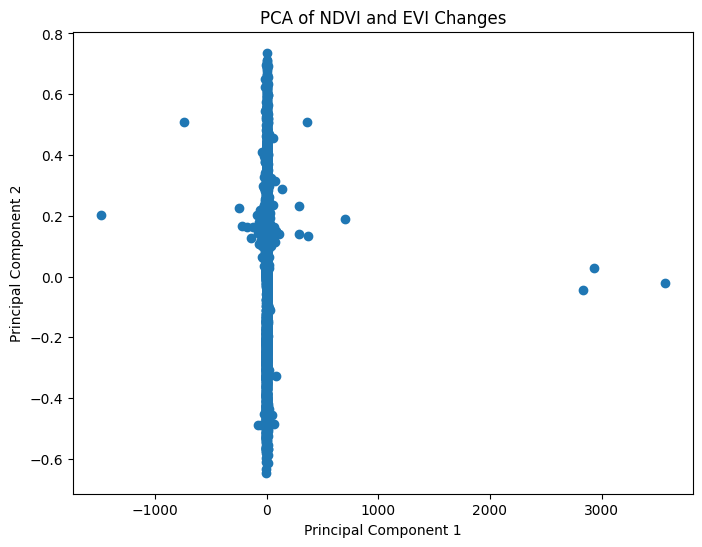

Explained variance by component: [9.99986027e-01 1.39734855e-05]


In [129]:
# @title
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

data = np.column_stack((ndvi_change_array, evi_change_array))

pca = PCA(n_components=2)
components = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of NDVI and EVI Changes')
plt.show()

print("Explained variance by component:", pca.explained_variance_ratio_)

In [130]:
# @title
import pandas as pd
import numpy as np
import scipy.stats as stats

ndvi_low_threshold = -0.01
ndvi_high_threshold = 0.01

ndvi_categories = np.where(ndvi_change_array < ndvi_low_threshold, 'Low',
                           np.where(ndvi_change_array <= ndvi_high_threshold, 'Medium', 'High'))

evi_low_threshold = -0.2
evi_high_threshold = 0.2

evi_categories = np.where(evi_change_array < evi_low_threshold, 'Low',
                          np.where(evi_change_array <= evi_high_threshold, 'Medium', 'High'))

In [131]:
ndvi_low = ndvi_change_array[ndvi_categories == 'Low']
ndvi_medium = ndvi_change_array[ndvi_categories == 'Medium']
ndvi_high = ndvi_change_array[ndvi_categories == 'High']

anova_result_ndvi = stats.f_oneway(ndvi_low, ndvi_medium, ndvi_high)
print("ANOVA Result for NDVI Change:", anova_result_ndvi)

evi_low = evi_change_array[evi_categories == 'Low']
evi_medium = evi_change_array[evi_categories == 'Medium']
evi_high = evi_change_array[evi_categories == 'High']

anova_result_evi = stats.f_oneway(evi_low, evi_medium, evi_high)
print("ANOVA Result for EVI Change:", anova_result_evi)

ANOVA Result for NDVI Change: F_onewayResult(statistic=133462.89511518896, pvalue=0.0)
ANOVA Result for EVI Change: F_onewayResult(statistic=251.3246453161804, pvalue=7.997178607258216e-110)


#### EVI Relacion a NDVI en Areas Marcados

In [132]:
# @title

df = pd.DataFrame({
    'NDVI_change': ndvi_change_array,
    'EVI_change': evi_change_array
})

ndvi_high_change_threshold = df['NDVI_change'].mean() + df['NDVI_change'].std()

ndvi_gain_mask = df['NDVI_change'] > ndvi_high_change_threshold
ndvi_loss_mask = df['NDVI_change'] < -ndvi_high_change_threshold

In [133]:
# @title
evi_change_in_ndvi_gain = df[ndvi_gain_mask]['EVI_change']
evi_change_in_ndvi_loss = df[ndvi_loss_mask]['EVI_change']

evi_change_gain_summary = evi_change_in_ndvi_gain.describe()
evi_change_loss_summary = evi_change_in_ndvi_loss.describe()
overall_evi_change_summary = df['EVI_change'].describe()

print("EVI Change in Areas of NDVI Gain:\n", evi_change_gain_summary)
print("\nEVI Change in Areas of NDVI Loss:\n", evi_change_loss_summary)
print("\nOverall EVI Change:\n", overall_evi_change_summary)

EVI Change in Areas of NDVI Gain:
 count    29674.000000
mean         0.076700
std          1.034722
min        -83.165901
25%         -0.004390
50%          0.085170
75%          0.183038
max         79.372340
Name: EVI_change, dtype: float64

EVI Change in Areas of NDVI Loss:
 count    360662.000000
mean         -0.003290
std           9.624451
min       -3564.555556
25%          -0.080236
50%           0.009860
75%           0.105125
max        1482.171175
Name: EVI_change, dtype: float64

Overall EVI Change:
 count    528796.000000
mean          0.014134
std           7.952528
min       -3564.555556
25%          -0.065270
50%           0.023044
75%           0.115463
max        1482.171175
Name: EVI_change, dtype: float64


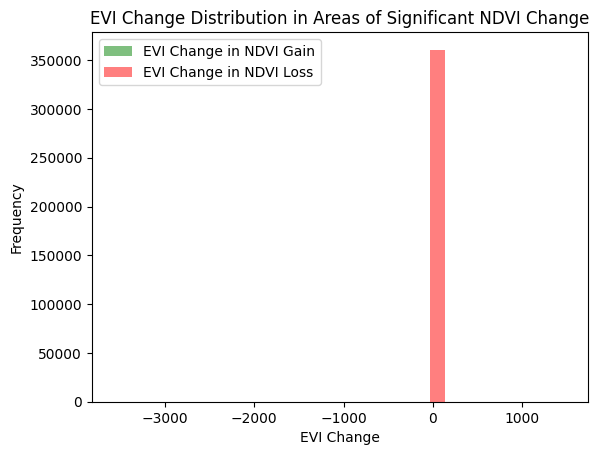

In [134]:
# @title
import matplotlib.pyplot as plt

plt.hist(evi_change_in_ndvi_gain, alpha=0.5, bins=30, label='EVI Change in NDVI Gain', color='green')
plt.hist(evi_change_in_ndvi_loss, alpha=0.5, bins=30, label='EVI Change in NDVI Loss', color='red')
plt.legend()
plt.title('EVI Change Distribution in Areas of Significant NDVI Change')
plt.xlabel('EVI Change')
plt.ylabel('Frequency')
plt.show()

# **Reporte**

## **Informe de Acción Basado en Análisis de NDVI y EVI**

### Resumen Ejecutivo:

Este informe revisa los cambios temporales en la salud y cobertura de la vegetación analizando los índices NDVI y EVI. La aplicación del Análisis de Componentes Principales (PCA) mostró una variabilidad dominante en una única dirección, lo que sugiere que los cambios en la vegetación están mayormente impulsados por un solo factor subyacente. Sin embargo, la significancia estadística de estas variaciones, confirmada por los resultados del ANOVA, junto con la correlación débil entre NDVI y EVI, presenta una imagen compleja de la dinámica vegetativa.

### Análisis de Cambios Significativos:

El NDVI, comúnmente asociado con la densidad vegetativa, mostró una disminución en el periodo observado, con una media de -0.0196 y una desviación estándar de 0.0298, indicando áreas potenciales de preocupación. Por otro lado, el EVI, que responde más a la estructura del dosel y las condiciones fisiológicas de las plantas, mostró una mayor variación en los cambios con una media de 0.0141 y una desviación estándar mucho mayor de 7.9317, lo que señala respuestas diferenciales de estos índices a los factores ambientales.

### Correlacion entre NDVI y EVI:

Los resultados de la regresión OLS muestran un R-cuadrado cercano a cero, indicando que no hay una relación fuerte entre los cambios en NDVI y EVI. Esto sugiere que los factores que afectan a cada índice varían en su influencia y pueden requerir estrategias de gestión diferenciadas.

### Recomendaciones para la Gestión de la Cosecha de Madera:
Las tendencias divergentes entre NDVI y EVI requieren un enfoque matizado para la gestión de la cosecha de madera:

- Los esfuerzos de conservación deben considerar tanto la cantidad como la calidad de la vegetación, especialmente en regiones donde los cambios de EVI son más pronunciados.
- Los programas de monitoreo deben adaptarse para incluir diversos índices de vegetación para capturar completamente la naturaleza multifacética de la salud vegetativa y las respuestas al estrés.

### Investigación y Análisis Adicionales Necesarios:

Es esencial realizar más investigaciones para comprender los impulsores detrás de los cambios observados:

- Se necesita una validación de campo detallada para determinar las causas de la desvinculación de las tendencias de NDVI y EVI.
- El monitoreo y análisis a largo plazo aclararía si estos cambios son parte de un ciclo natural, una respuesta a anomalías climáticas o el resultado de impactos antropogénicos.

### Políticas y Permisos para la Cosecha de Madera:

La relación matizada entre NDVI y EVI subraya la necesidad de marcos políticos dinámicos que puedan responder a señales ecológicas complejas:

- Las políticas deben basarse en evidencia, aprovechando un amplio conjunto de indicadores de teledetección para informar niveles de cosecha sostenibles y estrategias de regeneración.
- Los permisos deben incluir estipulaciones para el monitoreo continuo utilizando múltiples índices de vegetación para asegurar el cumplimiento de los criterios de sostenibilidad ambiental.

### Conclusión:

La relación entre los cambios en NDVI y EVI es indicativa de procesos ecológicos complejos que afectan la salud de la vegetación. La falta de una correlación fuerte en ciertas áreas sugiere impactos diferenciales en la cobertura y calidad de la vegetación, que pueden derivarse de una variedad de factores ambientales o antropogénicos. Por lo tanto, es crucial que las políticas de gestión de la cosecha de madera estén informadas por datos de teledetección comprensivos y multifacéticos. Esto garantizará que las prácticas de manejo sean robustas, sostenibles y sensibles a las sutilezas de la dinámica del ecosistema, apoyando tanto la viabilidad económica de la producción de madera como la integridad ecológica de los paisajes forestales.



##**Sugerencias para una mayor exploración y conocimientos prácticos:**

### 1. Temperatura de la superficie terrestre
### 2. Densidad del bosque
### 3. Cambio de biomasa
### 4. Degradación
### 5. Cambio de carbono